# Supplementary Note

In [1]:
import os
import pandas as pd
import numpy as np
import tqdm
import gzip
import pickle
import json
import glob

import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as itt

import sys

sys.path.append("../config/")
from config_plot import config_plot_params
from config import M_SIG_ACT_BASIC_FILTERS, RESULTS_BASIC_FILTERS, SIG_TREATMENT_DRUG_LVL, FIG_4

# Figure SN1 and SN2

In [2]:
# Results parser from files
def parse_results(base_path, files):
    results_dict = {}

    for fn in glob.glob(os.path.join(base_path, files)):
        foreign = fn.split('.')[-2]
        results = pd.read_csv(fn, sep='\t')
        results.reset_index(inplace=True)
        results.rename(columns={'index': 'sample'}, inplace=True)
        results.fillna(value=0, inplace=True)
        results['sample'] = results['sample'].apply(lambda s: s.split('_')[0])
        results['log_pval'] = results['pval'].apply(lambda x: -np.log10(x))
        results_dict[foreign] = results.copy()
    
    return results_dict

## Parse mSigAct results

In [3]:
results_dict = parse_results(M_SIG_ACT_BASIC_FILTERS, RESULTS_BASIC_FILTERS)

## Treatment regimens

In [4]:
with gzip.open(SIG_TREATMENT_DRUG_LVL, 'rb') as f:
    treatment_regimens = pickle.load(f)

In [5]:
carboplatin = treatment_regimens['PAN']['Carboplatin']
cisplatin = treatment_regimens['PAN']['Cisplatin']
oxaliplatin = treatment_regimens['PAN']['Oxaliplatin']
fluorouracil = treatment_regimens['PAN']['Fluorouracil']
capecitabine = treatment_regimens['PAN']['Capecitabine']

treated = {'carboplatin': carboplatin, 
           'cisplatin': cisplatin, 
           'oxaliplatin': oxaliplatin, 
           'fluorouracil': fluorouracil, 
           'capecitabine': capecitabine}

In [6]:
from config import UNTREATED_SAMPLES

# Untreated

with gzip.open(UNTREATED_SAMPLES, 'rb') as f:
    treated['untreated'] = json.load(f)

treated['platin'] = set.union(*[treated['carboplatin'], treated['cisplatin'], treated['oxaliplatin']])
treated['NMI'] = set.union(*[treated['capecitabine'], treated['fluorouracil']])

## Slice results

In [7]:
from config import M_SIG_ACT_OBSERVED_UNTREATED, M_SIG_ACT_CATALOGUE

# Recover the msigact runs with observed untreated

results_dict_untreated = parse_results(M_SIG_ACT_OBSERVED_UNTREATED, M_SIG_ACT_CATALOGUE)

In [8]:
def extract_sample(results):
    samples = results[foreign]['sample'].values
    samples_v = [i for i, s in enumerate(samples) if s in v]
    return results[foreign].loc[samples_v].copy()

treatment_slices = {}
for foreign in results_dict:
    treatment_slices[foreign] = {}
    for k, v in treated.items():
        if k == 'untreated':
            treatment_slices[foreign][k] = extract_sample(results_dict_untreated)
        else:
            treatment_slices[foreign][k] = extract_sample(results_dict)

# Figure SN1

In [9]:
# Regimen centric analysis

from matplotlib import cm
cmap = cm.get_cmap('Oranges')

def run_plot(save=False):

    for regimen in ['carboplatin', 'cisplatin', 'oxaliplatin', 'fluorouracil',
                    'capecitabine', 'untreated', 'platin', 'NMI']:

        fig, ax = plt.subplots(ncols=4, figsize=(20, 3))

        for i, foreign in enumerate(treatment_slices):

            v1 = treatment_slices[foreign][regimen][foreign].values
            sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, shade=False, cumulative=True, 
                        label=f'{regimen}: n={len(v1)}', color=cmap(0.9), lw=5, alpha=0.5)

            v0 = treatment_slices[foreign]['untreated'][foreign].values
            sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, shade=False, color='green', cumulative=True, 
                        label=f'untreated: n={len(v0)}', lw=5)

            ks, pval = scipy.stats.ks_2samp(v0, v1)

            ax[i].set_title(f'{foreign}')
            ax[i].set_ylim(0.85,)
            ax[i].set_xlabel('reconstructed exposure')
            ax[i].set_ylabel('cumulative density')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)

            ax[i].legend(title=f'KS pval={np.round(pval,2)}', loc=4)

        fig.suptitle(regimen)
        
        if save:
            
            plt.savefig(f'{FIG_4}/observed-treated-untreated.{regimen}.regimen-centric.close-up.svg', 
                        dpi=300, bbox_inches='tight')
            plt.savefig(f'{FIG_4}/observed-treated-untreated.{regimen}.regimen-centric.close-up.png', 
                        dpi=300, bbox_inches='tight')

    plt.show()

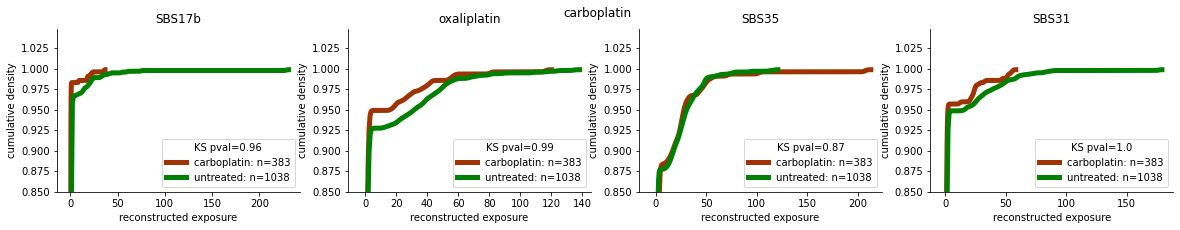

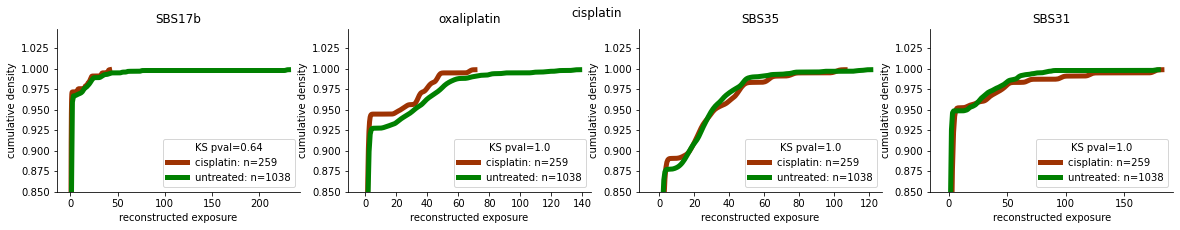

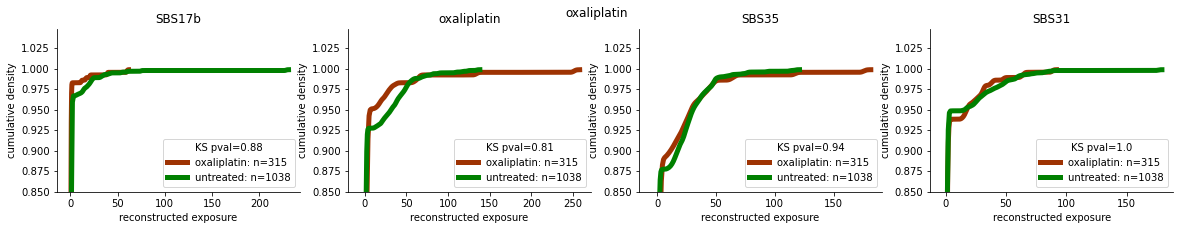

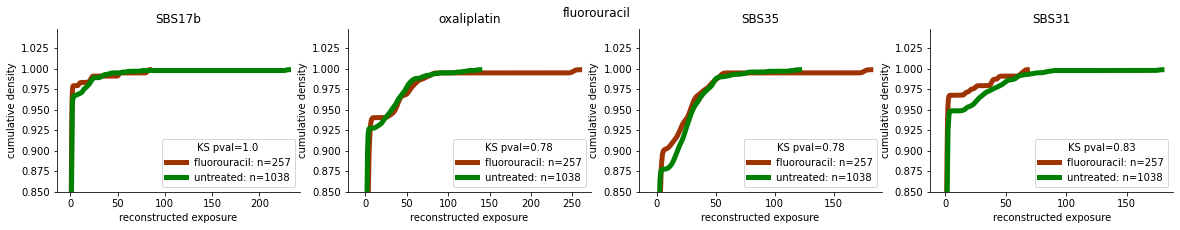

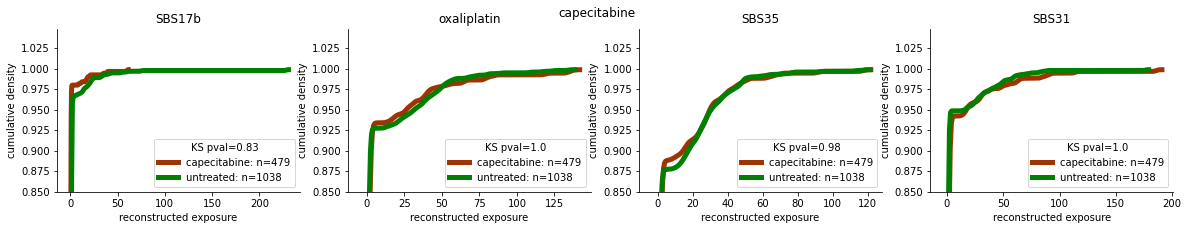

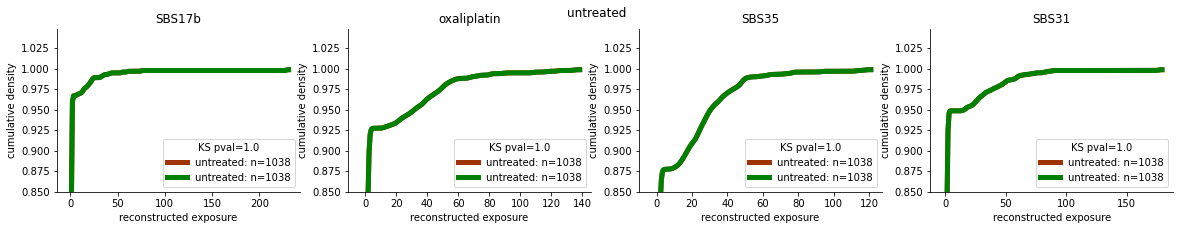

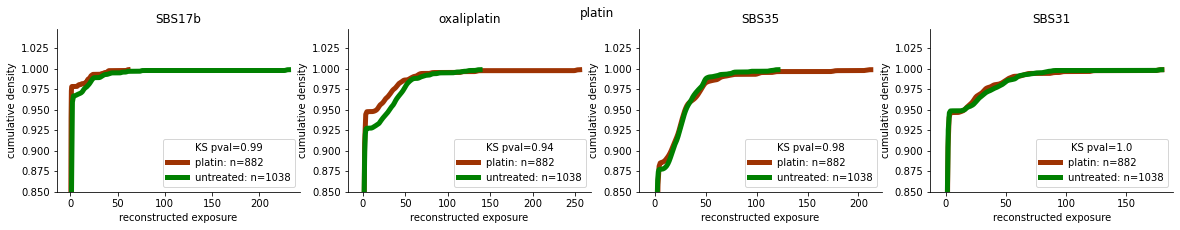

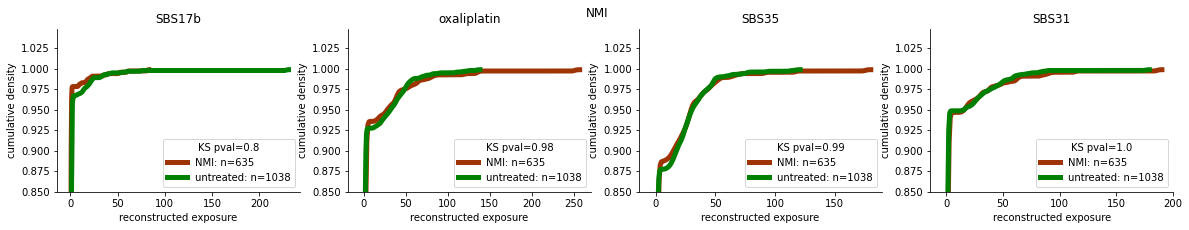

In [10]:
run_plot()

# Figure SN2

In [11]:
# Regimen centric + high exposure

from matplotlib import cm
cmap = cm.get_cmap('Oranges')

def run_plot(save=False):

    threshold = 5

    for regimen in ['carboplatin', 'cisplatin', 'oxaliplatin', 'fluorouracil',
                    'capecitabine', 'untreated', 'platin', 'NMI']:

        fig, ax = plt.subplots(ncols=4, figsize=(20, 3))

        for i, foreign in enumerate(treatment_slices):

            data = treatment_slices[foreign][regimen]
            data = data[data[foreign] >= threshold]

            v1 = data['log_pval'].values
            sns.kdeplot(v1, ax=ax[i], bw_method=0.4, shade=False, cumulative=True, 
                        label=f'{regimen}: n={len(v1)}', color=cmap(0.9), lw=5, alpha=0.5)

            data = treatment_slices[foreign]['untreated']
            data = data[data[foreign] >= threshold]

            v0 = data['log_pval'].values
            sns.kdeplot(v0, ax=ax[i], bw_method=0.4, shade=False, cumulative=True, 
                        label=f'untreated: n={len(v0)}', color='green', lw=5)

            ks, pval = scipy.stats.ks_2samp(v0, v1)

            ax[i].set_title(f'{foreign}')
            ax[i].set_xlim(-0.4, 6.4)
            ax[i].set_ylim(0.0, )
            ax[i].set_xlabel('$-\log_{10}$ pvalue')
            ax[i].set_ylabel('cumulative density')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].legend(title=f'KS pval={np.round(pval, 3)}', loc=4)

        fig.suptitle(regimen)
        
        if save:

            plt.savefig(f'{FIG_4}/observed-treated-untreated.{regimen}.pvalues.any-exposure.regimen-centric.{threshold}.svg',
                        dpi=300, bbox_inches='tight')
            plt.savefig(f'{FIG_4}/observed-treated-untreated.{regimen}.pvalues.any-exposure.regimen-centric.{threshold}.png', 
                        dpi=300, bbox_inches='tight')

    plt.show()

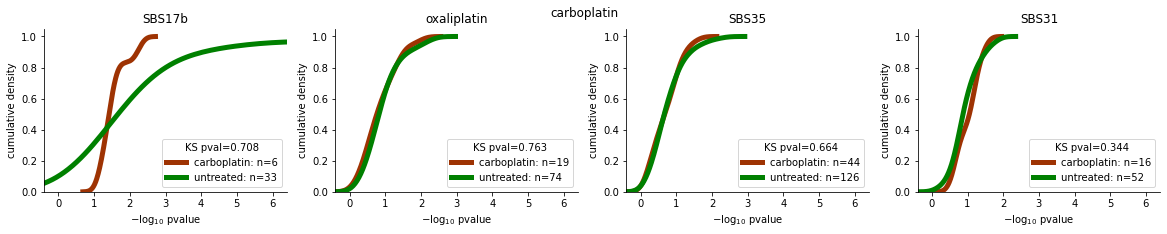

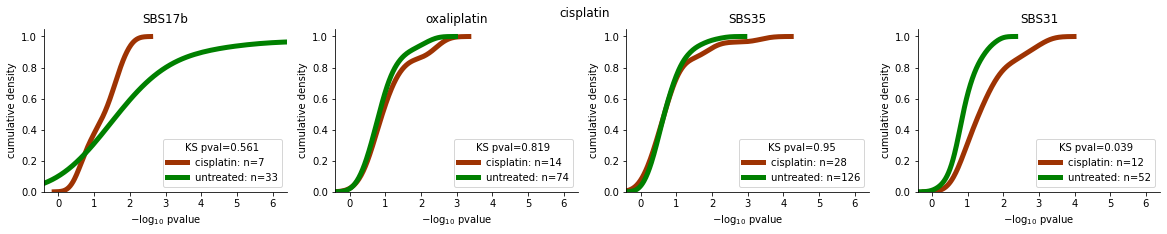

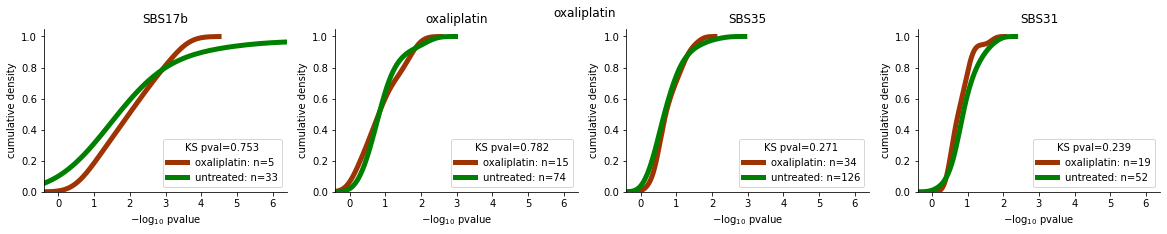

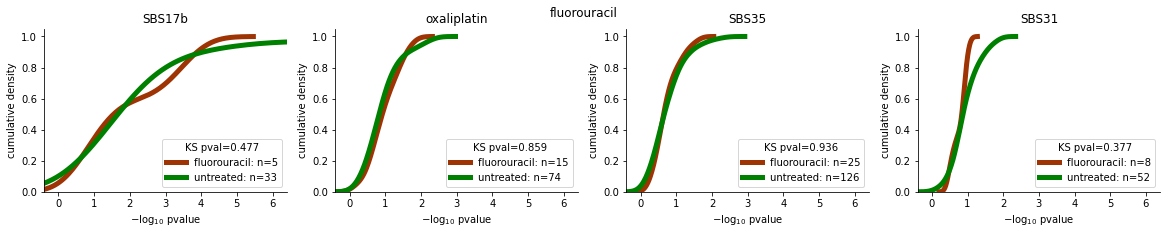

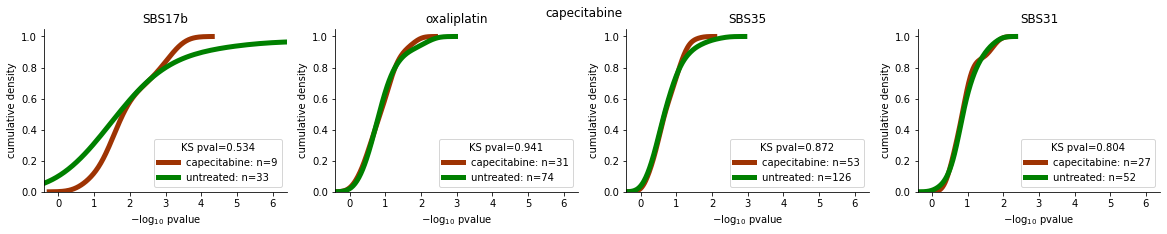

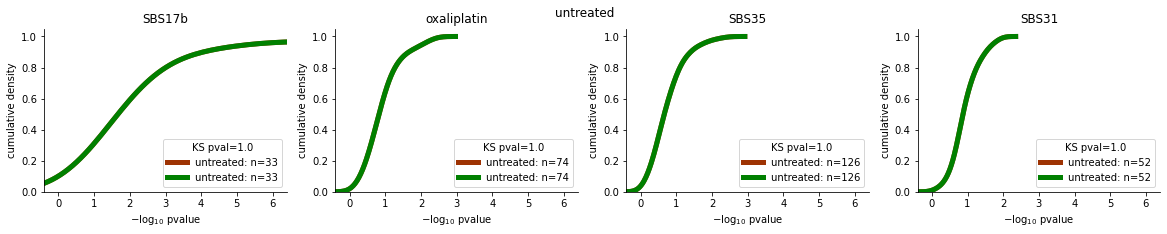

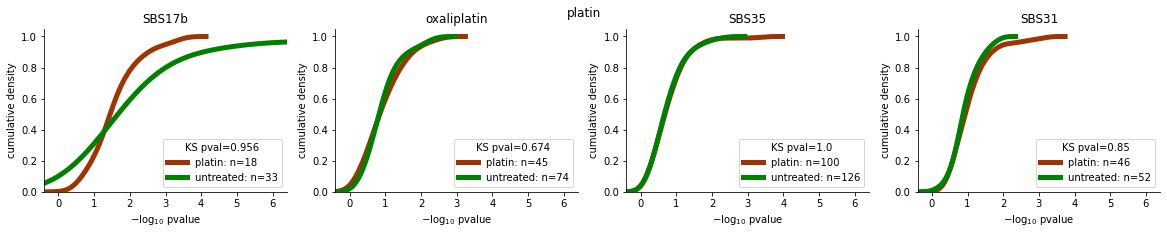

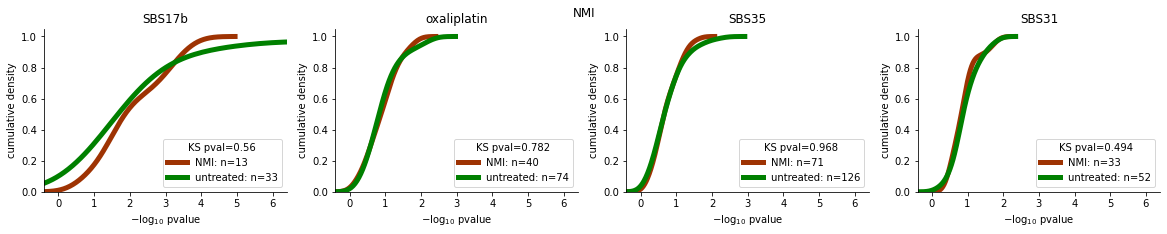

In [12]:
run_plot()

# Figure SN3

In [24]:
from config import M_SIG_ACT_OBSERVED_UNTREATED, RESULT_CATALOGUE

In [25]:
def formatting(sig):
    
    """
    Some formatting rules for more clear notation
    """
    
    if 'X' in sig:
        sig = sig[1:]
    if 'SBS17b' in sig:
        sig = 'SBS17b'
    
    return sig

In [26]:
df_list = []

for fn in glob.glob(os.path.join(M_SIG_ACT_OBSERVED_UNTREATED, RESULT_CATALOGUE)):
    
    if 'null' in fn:
        injected = 0
        foreign = formatting('.'.join(os.path.basename(fn).split('mSigAct')[-1].split('.')[1:-1]))
        
    else:
        injected = os.path.basename(fn).split('.tsv')[0].split('_')[-1]
        foreign  = formatting('_'.join(os.path.basename(fn).split('.tsv')[0].split('_')[1:-1]))

    df = pd.read_csv(fn, sep='\t')
    foreign_col_label = df.columns.tolist()[-1]
    df.rename(columns={foreign_col_label: formatting(foreign_col_label)}, inplace=True)
    
    df['injected'] = injected
    df['foreign'] = foreign
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'sample'}, inplace=True)
    
    df_list.append(df[['pval', 'sample', 'injected', 'foreign', formatting(foreign_col_label)]])

results = pd.concat(df_list)
results.fillna(value=0, inplace=True)
results['injected'] = results['injected'].apply(int)

## Reconstructed exposure by injected level

In [27]:
reconstructed = {}
for sig in results['foreign'].unique():
    for inj in results['injected'].unique():
        df = results[(results['foreign'] == sig) & (results['injected'] == inj)]
        reconstructed[(sig, inj)] = df.loc[:, [col for col in df.columns if col not in ['pval', 'sample', 'injected', 'foreign']]].sum(axis=1).tolist()

In [28]:
def run_plot(save=False):

    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 3))

    foreign = ['SBS17b', 'SBS35', 'oxaliplatin', 'SBS31']
    exposures = [2, 5, 7, 10, 15, 20, 25]
    colors = list(map(cmap, [(e+3)/25 for e in exposures]))

    for i, sig in enumerate(foreign):

        v0 = np.array(reconstructed[(sig, 0)])
        g0 = sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, color='green', 
                         shade=False, cumulative=True, label='zero injected', lw=5)

        for j, exp in enumerate(exposures):

            v1 = np.array(reconstructed[(sig, exp)])
            ks, pval = scipy.stats.ks_2samp(v0, v1)
            g = sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, color=colors[j],
                            shade=False, cumulative=True, alpha=0.5, lw=5, 
                            label=f'injected={exp}; KS pval={np.round(pval,2)}')

            ax[i].set_title(f'{sig}')
            ax[i].set_xlim(0, 150)
            ax[i].set_xlabel('reconstructed exposure')
            ax[i].set_ylabel('cumulative density')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].legend()
    
    if save:
        plt.savefig('reconstructed_vs_injected_onto_observed.all_samples.png', 
                    dpi=500, bbox_inches='tight')
    
    plt.show()    

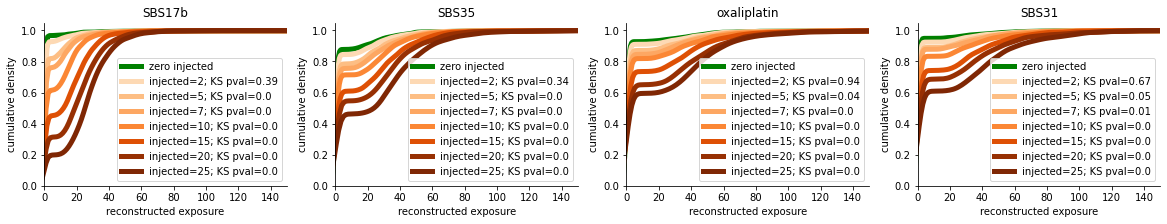

In [29]:
run_plot()

In [30]:
# compact version of the figure: close-up

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = cm.get_cmap('Oranges')

def run_plot(save=False):
    
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 3))

    foreign = ['SBS17b', 'SBS35', 'oxaliplatin', 'SBS31']
    exposures = [2, 5, 7, 10, 15, 20, 25]
    colors = list(map(cmap, [(e+4)/25 for e in exposures]))

    for i, sig in enumerate(foreign):

        v0 = np.array(reconstructed[(sig, 0)])
        g0 = sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, color='green', 
                         shade=False, cumulative=True, label='zero injected', lw=5)

        for j, exp in enumerate(exposures):

            v1 = np.array(reconstructed[(sig, exp)])
            ks, pval = scipy.stats.ks_2samp(v0, v1)
            g = sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, color=colors[j],
                            shade=False, cumulative=True, alpha=0.5, lw=5, 
                            label=f'injected={exp}; KS pval={np.round(pval,2)}')

            ax[i].set_title(f'{sig}')
            ax[i].set_xlim(-0.4, 70)
            ax[i].set_ylim(0.85,1.01)
            ax[i].set_xlabel('reconstructed exposure')
            ax[i].set_ylabel('cumulative density')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].legend()
    
    if save:

        plt.savefig('reconstructed_vs_injected.all_samples.close-up.png', 
                    dpi=300, bbox_inches='tight')
        plt.savefig('reconstructed_vs_injected.all_samples.close-up.svg', 
                    dpi=300, bbox_inches='tight')
    
    plt.show()

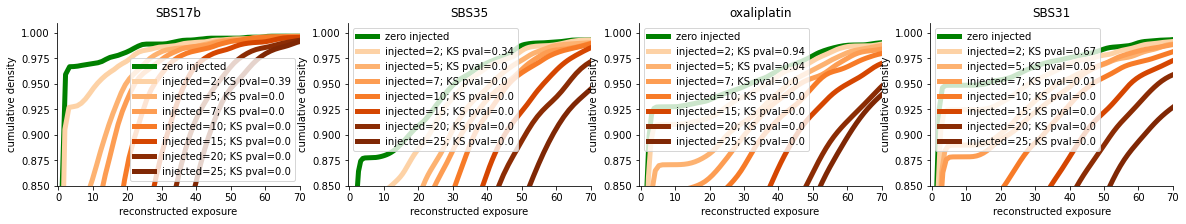

In [31]:
run_plot()

## p-values

In [32]:
def run_plot(save=False):
    
    data = results.copy()
    data['log_pval'] = data['pval'].apply(lambda x: -np.log10(x))

    cmap = cm.get_cmap('Oranges')

    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 3))

    foreign = ['SBS17b', 'SBS35', 'oxaliplatin', 'SBS31']
    exposures = [2, 5, 7, 10, 15, 20, 25]
    colors = list(map(cmap, [(e+3)/25 for e in exposures]))

    for i, sig in enumerate(foreign):

        v0 = data[(data['foreign'] == sig) & (data['injected'] == 0)]['log_pval'].values
        g0 = sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, shade=False, cumulative=True, 
                         color='green', label='zero injected', lw=5)

        for j, exp in enumerate(exposures):

            v1 = data[(data['foreign'] == sig) & (data['injected'] == exp)]['log_pval'].values

            ks, pval = scipy.stats.ks_2samp(v0, v1)

            g = sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, shade=False, cumulative=True, 
                            color=colors[j], 
                            label=f'injected={exp} KS pval={np.round(pval,2)}', 
                            alpha=0.5, lw=5)

            ax[i].set_ylabel('cumulative density')
            ax[i].set_xlabel('-$\log_{10}$ pvalue')
            ax[i].set_title(f'{sig}')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].set_ylim(0.6, 1.01)
            ax[i].set_xlim(-0.4, 10)

    if save:

        plt.savefig(f'{FIG_4}/reconstructed_vs_injected.pval.all_samples.png', 
                    dpi=500, bbox_inches='tight')
        plt.savefig(f'{FIG_4}/reconstructed_vs_injected.pval.all_samples.svg', 
                    dpi=500, bbox_inches='tight')
    
    plt.show()

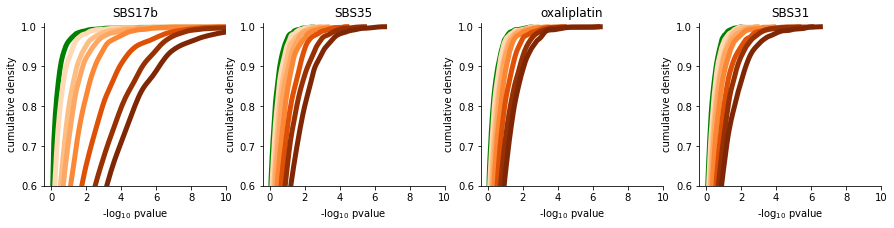

In [33]:
run_plot()

# Figure SN4

In [34]:
from config import BASIC_FILTERS, RESULT_CATALOGUE

In [35]:
def formatting(sig):
    
    """
    Some formatting rules for more clear notation
    """
    
    if 'X' in sig:
        sig = sig[1:]
    if 'SBS17b' in sig:
        sig = 'SBS17b'
    
    return sig

In [36]:
df_list = []

for fn in glob.glob(os.path.join(BASIC_FILTERS, RESULT_CATALOGUE)):
    
    if 'null' in fn:
        injected = 0
        foreign = formatting('.'.join(os.path.basename(fn).split('mSigAct')[-1].split('.')[1:-1]))
        
    else:
        injected = os.path.basename(fn).split('.tsv')[0].split('_')[-1]
        foreign  = formatting('_'.join(os.path.basename(fn).split('.tsv')[0].split('_')[1:-1]))

    df = pd.read_csv(fn, sep='\t')
    foreign_col_label = df.columns.tolist()[-1]
    df.rename(columns={foreign_col_label: formatting(foreign_col_label)}, inplace=True)
    
    df['injected'] = injected
    df['foreign'] = foreign
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'sample'}, inplace=True)
    
    df_list.append(df[['pval', 'sample', 'injected', 'foreign', formatting(foreign_col_label)]])

results = pd.concat(df_list)
results.fillna(value=0, inplace=True)
results['injected'] = results['injected'].apply(int)

## Reconstructed exposure by injected level

In [37]:
reconstructed = {}
for sig in results['foreign'].unique():
    for inj in results['injected'].unique():
        df = results[(results['foreign'] == sig) & (results['injected'] == inj)]
        reconstructed[(sig, inj)] = df.loc[:, [col for col in df.columns if col not in ['pval', 'sample', 'injected', 'foreign']]].sum(axis=1).tolist()

In [38]:
def run_plot(save=False):

    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 3))

    foreign = ['SBS17b', 'SBS35', 'oxaliplatin', 'SBS31']
    exposures = [2, 5, 7, 10, 15, 20, 25]
    colors = list(map(cmap, [(e+3)/25 for e in exposures]))

    for i, sig in enumerate(foreign):

        v0 = np.array(reconstructed[(sig, 0)])
        g0 = sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, color='green', 
                         shade=False, cumulative=True, label='zero injected', lw=5)

        for j, exp in enumerate(exposures):

            v1 = np.array(reconstructed[(sig, exp)])
            ks, pval = scipy.stats.ks_2samp(v0, v1)
            g = sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, color=colors[j],
                            shade=False, cumulative=True, alpha=0.5, lw=5, 
                            label=f'injected={exp}; KS pval={np.round(pval,2)}')

            ax[i].set_title(f'{sig}')
            ax[i].set_xlim(0, 150)
            ax[i].set_xlabel('reconstructed exposure')
            ax[i].set_ylabel('cumulative density')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].legend()
    
    if save:
        plt.savefig(f'{FIG_4}/reconstructed_vs_injected_onto_observed.all_samples.png', 
                    dpi=500, bbox_inches='tight')
    
    plt.show()    

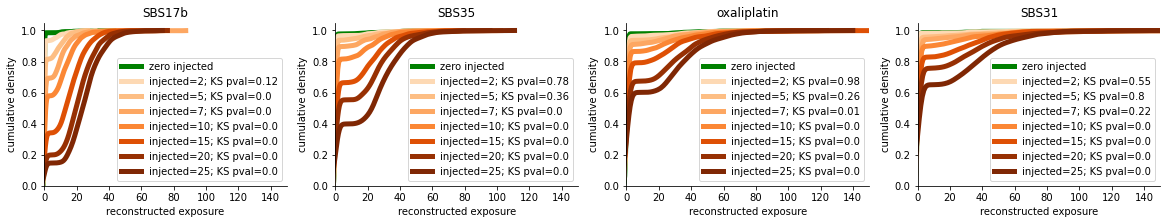

In [39]:
run_plot()

In [40]:
# compact version of the figure: close-up

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = cm.get_cmap('Oranges')

def run_plot(save=False):
    
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 3))

    foreign = ['SBS17b', 'SBS35', 'oxaliplatin', 'SBS31']
    exposures = [2, 5, 7, 10, 15, 20, 25]
    colors = list(map(cmap, [(e+4)/25 for e in exposures]))

    for i, sig in enumerate(foreign):

        v0 = np.array(reconstructed[(sig, 0)])
        g0 = sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, color='green', 
                         shade=False, cumulative=True, label='zero injected', lw=5)

        for j, exp in enumerate(exposures):

            v1 = np.array(reconstructed[(sig, exp)])
            ks, pval = scipy.stats.ks_2samp(v0, v1)
            g = sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, color=colors[j],
                            shade=False, cumulative=True, alpha=0.5, lw=5, 
                            label=f'injected={exp}; KS pval={np.round(pval,2)}')

            ax[i].set_title(f'{sig}')
            ax[i].set_xlim(-0.4, 70)
            ax[i].set_ylim(0.85,1.01)
            ax[i].set_xlabel('reconstructed exposure')
            ax[i].set_ylabel('cumulative density')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].legend()
    
    if save:

        plt.savefig('reconstructed_vs_injected.all_samples.close-up.png', 
                    dpi=300, bbox_inches='tight')
        plt.savefig('reconstructed_vs_injected.all_samples.close-up.svg', 
                    dpi=300, bbox_inches='tight')
    
    plt.show()

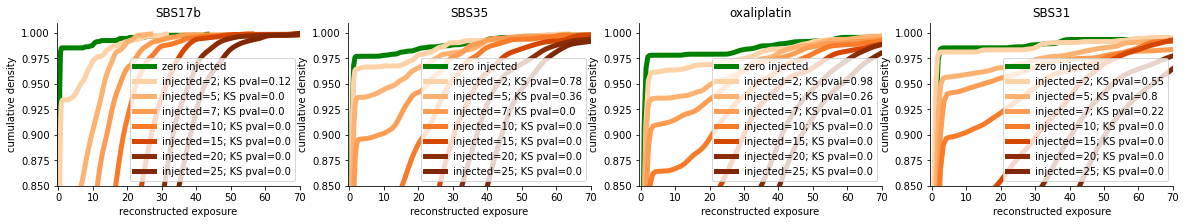

In [41]:
run_plot()

## p-values

In [42]:
def run_plot(save=False):
    
    data = results.copy()
    data['log_pval'] = data['pval'].apply(lambda x: -np.log10(x))

    cmap = cm.get_cmap('Oranges')

    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 3))

    foreign = ['SBS17b', 'SBS35', 'oxaliplatin', 'SBS31']
    exposures = [2, 5, 7, 10, 15, 20, 25]
    colors = list(map(cmap, [(e+3)/25 for e in exposures]))

    for i, sig in enumerate(foreign):

        v0 = data[(data['foreign'] == sig) & (data['injected'] == 0)]['log_pval'].values
        g0 = sns.kdeplot(v0, ax=ax[i], bw_adjust=0.4, shade=False, cumulative=True, 
                         color='green', label='zero injected', lw=5)

        for j, exp in enumerate(exposures):

            v1 = data[(data['foreign'] == sig) & (data['injected'] == exp)]['log_pval'].values

            ks, pval = scipy.stats.ks_2samp(v0, v1)

            g = sns.kdeplot(v1, ax=ax[i], bw_adjust=0.4, shade=False, cumulative=True, 
                            color=colors[j], 
                            label=f'injected={exp} KS pval={np.round(pval,2)}', 
                            alpha=0.5, lw=5)

            ax[i].set_ylabel('cumulative density')
            ax[i].set_xlabel('-$\log_{10}$ pvalue')
            ax[i].set_title(f'{sig}')
            ax[i].spines['top'].set_visible(False)
            ax[i].spines['right'].set_visible(False)
            ax[i].set_ylim(0.6, 1.01)
            ax[i].set_xlim(-0.4, 10)

    if save:

        plt.savefig(f'{FIG_4}/reconstructed_vs_injected.pval.all_samples.png', 
                    dpi=500, bbox_inches='tight')
        plt.savefig(f'{FIG_4}/reconstructed_vs_injected.pval.all_samples.svg', 
                    dpi=500, bbox_inches='tight')
    
    plt.show()

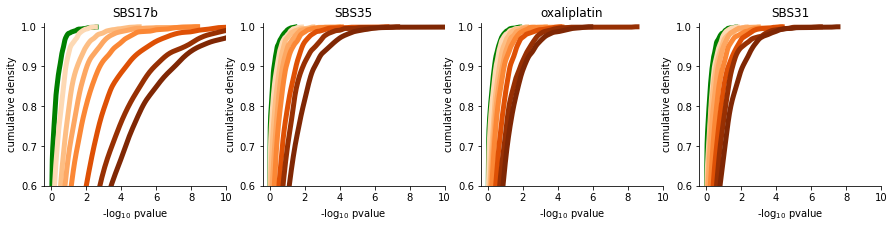

In [43]:
run_plot()